In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation
from pathlib import Path

In [7]:
! pip install kaggle

from google.colab import drive
drive.mount('/content/drive')

! mkdir ~/.kaggle
# Upload your Kaggle API token to your google drive as json file and then change the path in the below line before running.
!cp /content/kaggle.json ~/.kaggle/kaggle.json

! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download sonilnegi/spotted-cats-images
! unzip spotted-cats-images.zip

Mounted at /content/drive
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/sonilnegi/spotted-cats-images
License(s): CC0-1.0
100% 426M/427M [00:04<00:00, 116MB/s]
100% 427M/427M [00:04<00:00, 106MB/s]
Archive:  spotted-cats-images.zip
  inflating: a/cheetahs/011c7ffc-8533-4166-aa30-b95f5b1c3884.jpg  
  inflating: a/cheetahs/0238989e-1c32-4529-b438-1bcf0d6419e5.jpg  
  inflating: a/cheetahs/04c7c77a-2e80-458b-8d50-23034aee5b89.jpg  
  inflating: a/cheetahs/09f51628-4674-468f-8662-fb2f94db5652.jpg  
  inflating: a/cheetahs/0cfc61de-7287-4ef9-bc47-98af670d2809.jpg  
  inflating: a/cheetahs/0d286599-9094-478b-9eeb-294fc6fa9692.jpg  
  inflating: a/cheetahs/0d29a5f5-da38-4dc5-a491-7b7b26725f07.jpg  
  inflating: a/cheetahs/0d344b9c-8852-4bc9-8034-38652b859262.jpg  
  inflating: a/cheetahs/0dfcc9fb-1d49-4b98-9d37-e65ff321030b.jpg  
  inflating: a/cheetahs/13c9bb42-e6d0-4c21-94bf-ed5a7cbc5e14.jpg  
  inflating: a/cheetahs/160155de-9dd8-4

In [8]:
path = Path('/content/cats_projekat/')
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(path,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE,validation_split=0.2, subset='training', seed=42)
validation_dataset = image_dataset_from_directory(path, shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE,validation_split=0.2,subset='validation',seed=42)

Found 2149 files belonging to 3 classes.
Using 1720 files for training.
Found 2149 files belonging to 3 classes.
Using 429 files for validation.


In [67]:
# after you create train_dataset with image_dataset_from_directory(...)
print("train_dataset.class_names:", train_dataset.class_names)
# build a mapping:
idx_to_class = {i: name for i, name in enumerate(train_dataset.class_names)}
print("idx_to_class:", idx_to_class)


AttributeError: '_MapDataset' object has no attribute 'class_names'

In [9]:
cheetah_path = Path(path/'cheetahs')
jaguar_path = Path(path/'jaguars')
leopard_path = Path(path/'leopards')

In [10]:
file_count = len([f for f in cheetah_path.iterdir() if f.is_file()])
print(f"Number of files in {cheetah_path.name}: {file_count}")
file_count = len([f for f in jaguar_path.iterdir() if f.is_file()])
print(f"Number of files in {jaguar_path.name}: {file_count}")
file_count = len([f for f in leopard_path.iterdir() if f.is_file()])
print(f"Number of files in {leopard_path.name}: {file_count}")

Number of files in cheetahs: 717
Number of files in jaguars: 704
Number of files in leopards: 728


In [12]:
total = 0
for batch in train_dataset:
    total += batch[0].shape[0]
print(total)

1720


In [13]:
class_names = train_dataset.class_names
print(class_names)

['cheetahs', 'jaguars', 'leopards']


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)

In [16]:
NUM_CLASSES = 3
def one_hot_encode(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

In [17]:
train_dataset = train_dataset.map(one_hot_encode)
validation_dataset = validation_dataset.map(one_hot_encode)

In [19]:

def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    return data_augmentation
data_augmentation = data_augmenter()

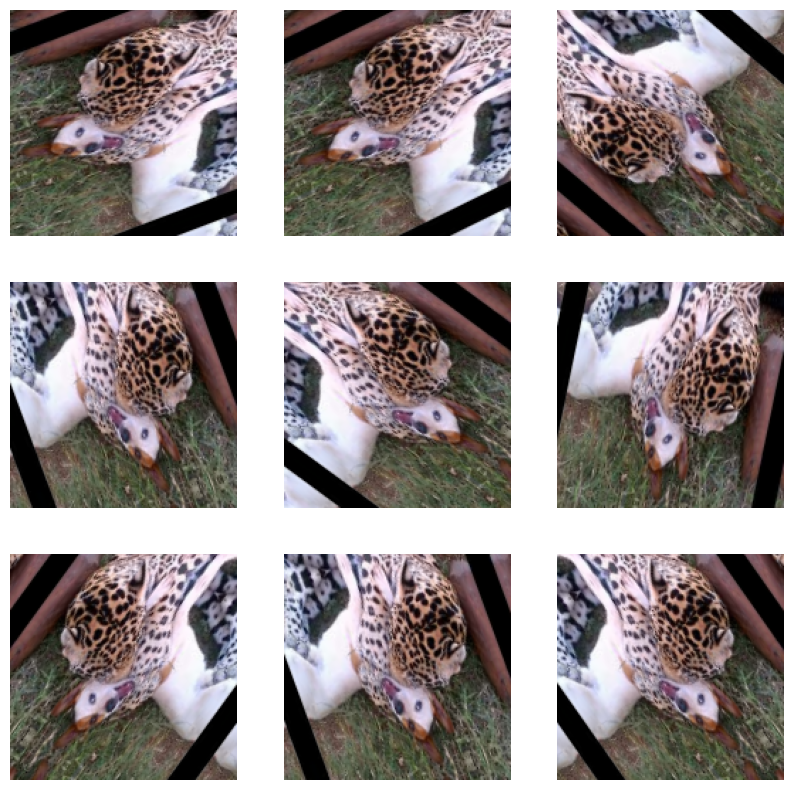

In [20]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [21]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [25]:
IMG_SHAPE = IMG_SIZE + (3,)
#base_model_path="imagenet_base_model/with_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160.h5"
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [26]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [32]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)
global_average_pooling2d_6
predictions

global_average_pooling2d_1
predictions


NameError: name 'global_average_pooling2d_6' is not defined

In [31]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [41]:
def bigcat_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):

    #to make sure the model expects RGB images as input.
    input_shape = image_shape + (3,)

    #load mobilenet_v2 as base feature extractor without including final classification layers.
    base_model_path="imagenet_base_model/without_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5"
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape= input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tfl.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(3)(x)
    model = tf.keras.Model(inputs, outputs)
    return model


In [42]:
model2 = bigcat_model(IMG_SIZE)

In [43]:
model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [44]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4626 - loss: 1.2037 - val_accuracy: 0.6783 - val_loss: 0.7083
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.6816 - loss: 0.7389 - val_accuracy: 0.6876 - val_loss: 0.6862
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.6974 - loss: 0.6951 - val_accuracy: 0.7063 - val_loss: 0.6638
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6964 - loss: 0.6864 - val_accuracy: 0.7436 - val_loss: 0.5893
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7250 - loss: 0.6316 - val_accuracy: 0.7506 - val_loss: 0.5840


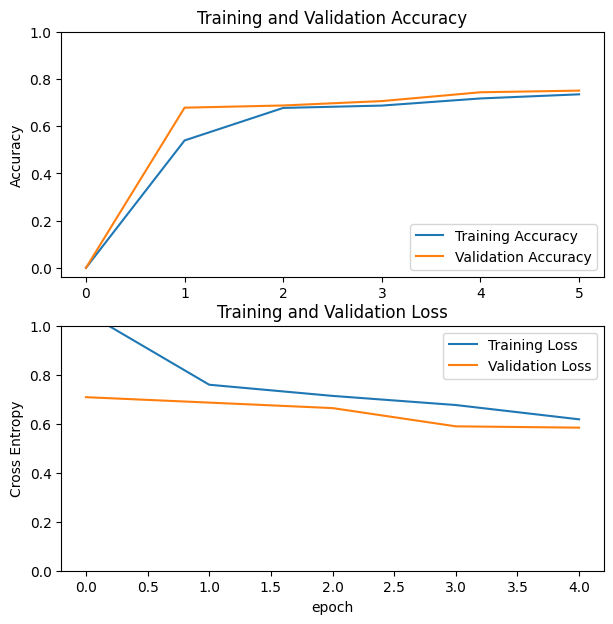

In [46]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(7,7))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [70]:
path1 = Path('/content/a/')

IMG_SIZE = (160, 160)
test_dataset = image_dataset_from_directory(path1, shuffle=False, image_size=IMG_SIZE,  seed=42)
class_names2 = test_dataset.class_names
print(class_names2)

# One hot encoding of test data
NUM_CLASSES = 3  # cheetahs, jaguars, leopards

def one_hot_encode(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

test_dataset = test_dataset.map(one_hot_encode)
from pathlib import Path
from PIL import Image

test_dir = path1
for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.iterdir():
            try:
                img = Image.open(img_path)
                img.verify()  # Verify that it is, in fact, an image
            except Exception as e:
                print(f"Removing corrupted file: {img_path}")
                img_path.unlink()  # Remove the file
import imghdr
from pathlib import Path

test_dir = path1

for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.iterdir():
            img_type = imghdr.what(img_path)
            if img_type not in ['jpeg', 'png', 'bmp', 'gif']:
                print(f"Removing non-image or unsupported file: {img_path}")
                img_path.unlink()
results = model2.evaluate(test_dataset)
print("Test Accuracy :",results[1])

Found 483 files belonging to 3 classes.
['cheetahs', 'jaguars', 'leopards']
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9244 - loss: 0.2958
Test Accuracy : 0.8674948215484619


In [48]:
base_model.trainable = True

In [49]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  156


In [51]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = None
loss_function= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001
# Use accuracy as evaluation metric
metrics=['accuracy']

In [52]:
model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [53]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7197 - loss: 0.6131 - val_accuracy: 0.7552 - val_loss: 0.5818
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7480 - loss: 0.5783 - val_accuracy: 0.7552 - val_loss: 0.5792
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7597 - loss: 0.5742 - val_accuracy: 0.7529 - val_loss: 0.5783
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.7682 - loss: 0.5578 - val_accuracy: 0.7529 - val_loss: 0.5762
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7642 - loss: 0.5561 - val_accuracy: 0.7552 - val_loss: 0.5766
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7550 - loss: 0.5699 - val_accuracy: 0.7529 - val_loss: 0.5735


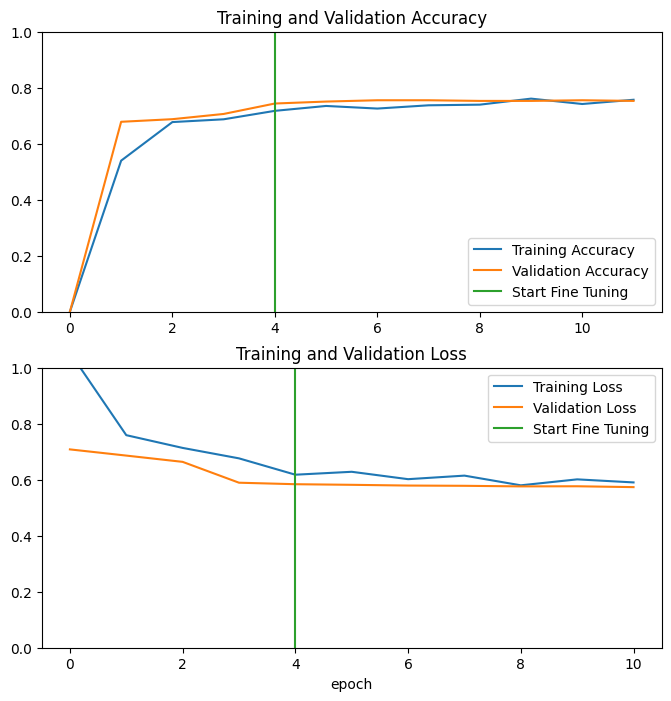

In [54]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [55]:
path1 = Path('/content/a/')

IMG_SIZE = (160, 160)
test_dataset = image_dataset_from_directory(path1, shuffle=False, image_size=IMG_SIZE,  seed=42)
class_names2 = test_dataset.class_names
print(class_names2)

# One hot encoding of test data
NUM_CLASSES = 3  # cheetahs, jaguars, leopards

def one_hot_encode(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

test_dataset = test_dataset.map(one_hot_encode)
from pathlib import Path
from PIL import Image

test_dir = path1
for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.iterdir():
            try:
                img = Image.open(img_path)
                img.verify()  # Verify that it is, in fact, an image
            except Exception as e:
                print(f"Removing corrupted file: {img_path}")
                img_path.unlink()  # Remove the file
import imghdr
from pathlib import Path

test_dir = path1

for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.iterdir():
            img_type = imghdr.what(img_path)
            if img_type not in ['jpeg', 'png', 'bmp', 'gif']:
                print(f"Removing non-image or unsupported file: {img_path}")
                img_path.unlink()
results = model2.evaluate(test_dataset)
print("Test Accuracy :",results[1])

Found 483 files belonging to 3 classes.
['cheetahs', 'jaguars', 'leopards']
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 997ms/step - accuracy: 0.9244 - loss: 0.2958
Test Accuracy : 0.8674948215484619


In [78]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def make_prediction(image_path):
    # Define class labels in the same order as your training data
    class_labels = ['cheetahs', 'jaguars', 'leopards']  # Change to your actual 3 classes

    # Load and preprocess the image
    img = load_img(image_path, target_size=(160, 160)) # Changed target size to match IMG_SIZE
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make prediction
    prediction = model2.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]
    predicted_prob = prediction[0][predicted_class_index]

    print(f"Prediction: {prediction}")
    print(f"Predicted Class: {predicted_class_label} ({predicted_prob*100:.2f}% confidence)")

    # Plot images
    plt.figure(figsize=(10, 5)) # Adjusted figure size for better display
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_label}")
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Prediction: [[ 0.18181013 -0.8187407   0.7522796 ]]
Predicted Class: leopards (75.23% confidence)


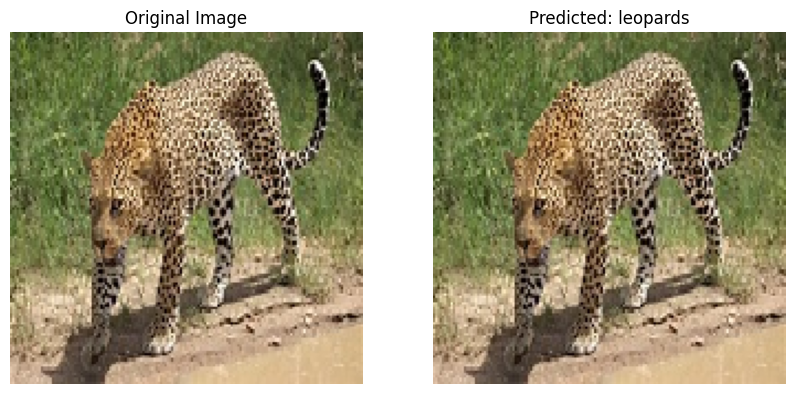

In [79]:
img_path = '/content/leo.jpeg'
make_prediction(img_path)

*italicized text*